# *El problema de n-círculos*

Dado un conjunto *C* de *n* círculos y un conjunto *P* de *m* puntos, encontrar todos los círculos en *C* que están vacíos.

## Preliminares

### Ejemplo Gráfico

In [1]:
# # --- Data ---
# circles = [
#     ((3.5, 11.5), 1.5),
#     ((6.5, 8.5),  1.5),
#     ((5.0, 10.0), 1.0),
#     ((7.0, 5.0),  1.0),
#     ((8.0, 5.0),  1.0),
#     ((7.5, 4.0),  1.0),
#     ((14.5, 10.5), 1.5),
#     ((14,6), 2)
# ]

# points = [(4.3, 10.5), (7.5, 4.5), (10.0, 5.0), (14.5, 10.5), (4.5,12), (5,10), (12,4), (4,6)]
import tikzplotlib

In [2]:
# --- Data ---
circles = [
    ((7.5, 4), 2.5),
    ((6, 4),  3),
    ((4, 11), 3),
    ((4, 17), 4),
    ((4, 23), 3),
    ((7, 17), 4.5),
    ((9.5, 30.5), 3.5),
    ((11, 30.5), 3.5),
    ((18, 5), 5),
    ((18, 15), 6),
    ((18, 24), 5),
    ((12, 9), 2),
    ((12.5,17), 3),
    ((16,9),3),
    ((27,19),3),
    ((30,17),3)
]

points = [
    (28, 18), 
    (9, 17), 
    (18, 9.5), 
    (18, 20), 
    (11, 5), 
    (14, 30.5)
]


In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from typing import List, Tuple, Optional, Dict, Any

Coord = Tuple[float, float]
CircleSpec = Tuple[Coord, float]

def plot_circles_points(
    circles: Optional[List[CircleSpec]] = None,
    points: Optional[List[Coord]] = None,
    *,
    annotations: Optional[List[Dict[str, Any]]] = None,
    # vertical line options
    show_vline: bool = False,
    vline_x: float = 1.0,
    vline_kwargs: Optional[dict] = None,
    # styling
    circle_kwargs: Optional[dict] = None,
    point_kwargs: Optional[dict] = None,
    title: Optional[str] = "Circles and Points",
    ax: Optional[plt.Axes] = None,
    show: bool = True,
    marker ="."
):
    """
    Plot circles/points, with fully generic labels.

    circles: list of ((cx, cy), r)
    points:  list of (x, y)

    annotations: list of dicts. Each dict can be:
      {
        "anchor": "circle" | "point" | "xy",   # default: "xy"
        "index": int,                          # required when anchor is "circle"/"point" (0-based)
        "xy": (x, y),                          # required when anchor is "xy"
        "text": "Your label text",             # required
        "pos": (x, y),                         # optional: where to place the text (if omitted, placed at anchor)
        "arrow": bool,                         # optional: if True and pos given, draw arrow from anchor -> pos
        "style": {...},                        # optional: passed to text/annotate (e.g., ha, va, fontsize)
        "arrowprops": {...}                    # optional: passed to annotate for arrow styling
      }

    Notes:
      - Labels are independent from the number of circles/points.
      - If 'pos' is supplied and 'arrow' is True, we use ax.annotate with an arrow.
      - If 'pos' is supplied and 'arrow' is False, we place text at 'pos' with no arrow.
      - If 'pos' is omitted, we place text at the anchor point.
    """
    circles = circles or []
    points = points or []
    annotations = annotations or []

    circle_kwargs = circle_kwargs or {"fill": False, "linewidth": 2}
    point_kwargs = point_kwargs or {"s": 60, "zorder": 3, "marker": marker,}
    vline_kwargs = vline_kwargs or {"linestyle": "--", "linewidth": 1, "alpha": 0.8}

    created_fig = None
    if ax is None:
        created_fig, ax = plt.subplots(figsize=(15, 15))

    # --- Draw circles ---
    for ((cx, cy), r) in circles:
        ax.add_patch(Circle((cx, cy), r, **circle_kwargs))

    # --- Draw points ---
    if points:
        xs, ys = zip(*points)
        ax.scatter(xs, ys, **point_kwargs)

    # --- Draw optional vertical line ---
    if show_vline:
        ax.axvline(vline_x, **vline_kwargs)

    # --- Annotations (generic) ---
    def _anchor_xy(a: Dict[str, Any]) -> Optional[Coord]:
        anchor = a.get("anchor", "xy")
        if anchor == "circle":
            i = a.get("index")
            if i is None or i < 0 or i >= len(circles):
                return None
            return circles[i][0]
        elif anchor == "point":
            i = a.get("index")
            if i is None or i < 0 or i >= len(points):
                return None
            return points[i]
        else:  # "xy"
            return a.get("xy")

    for a in annotations:
        text = a.get("text", "")
        if not text:
            continue
        anc = _anchor_xy(a)
        if anc is None:
            continue  # skip malformed annotation

        pos = a.get("pos")  # where to place text; if None, at anchor
        style = a.get("style", {})
        arrow = a.get("arrow", (pos is not None))  # default: arrow if pos given
        arrowprops = a.get("arrowprops", {"arrowstyle": "->", "lw": 1})

        if pos is None:
            # place text at the anchor
            default_style = {"ha": "center", "va": "center"}
            default_style.update(style)
            ax.text(anc[0], anc[1], str(text), **default_style)
        else:
            if arrow:
                default_style = {"ha": "left", "va": "bottom"}
                default_style.update(style)
                ax.annotate(str(text), xy=anc, xytext=pos, arrowprops=arrowprops, **default_style)
            else:
                default_style = {"ha": "left", "va": "bottom"}
                default_style.update(style)
                ax.text(pos[0], pos[1], str(text), **default_style)

    # --- Bounds (include circles, points, and any annotation positions) ---
    xs, ys = [], []
    for (cx, cy), r in circles:
        xs.extend([cx - r, cx + r]); ys.extend([cy - r, cy + r])
    for (px, py) in points:
        xs.append(px); ys.append(py)
    for a in annotations:
        if "pos" in a and isinstance(a["pos"], (tuple, list)):
            xs.append(a["pos"][0]); ys.append(a["pos"][1])
        if a.get("anchor", "xy") == "xy" and "xy" in a and isinstance(a["xy"], (tuple, list)):
            xs.append(a["xy"][0]); ys.append(a["xy"][1])

    if xs and ys:
        pad = 0.5
        ax.set_xlim(min(xs) - pad, max(xs) + pad)
        ax.set_ylim(min(ys) - pad, max(ys) + pad)

    ax.set_aspect("equal", adjustable="box")
    ax.grid(True)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    if title:
        ax.set_title(title)

    if show and created_fig is not None:
        plt.savefig("figure.pdf", bbox_inches="tight")
        plt.show()
        
    return created_fig, ax


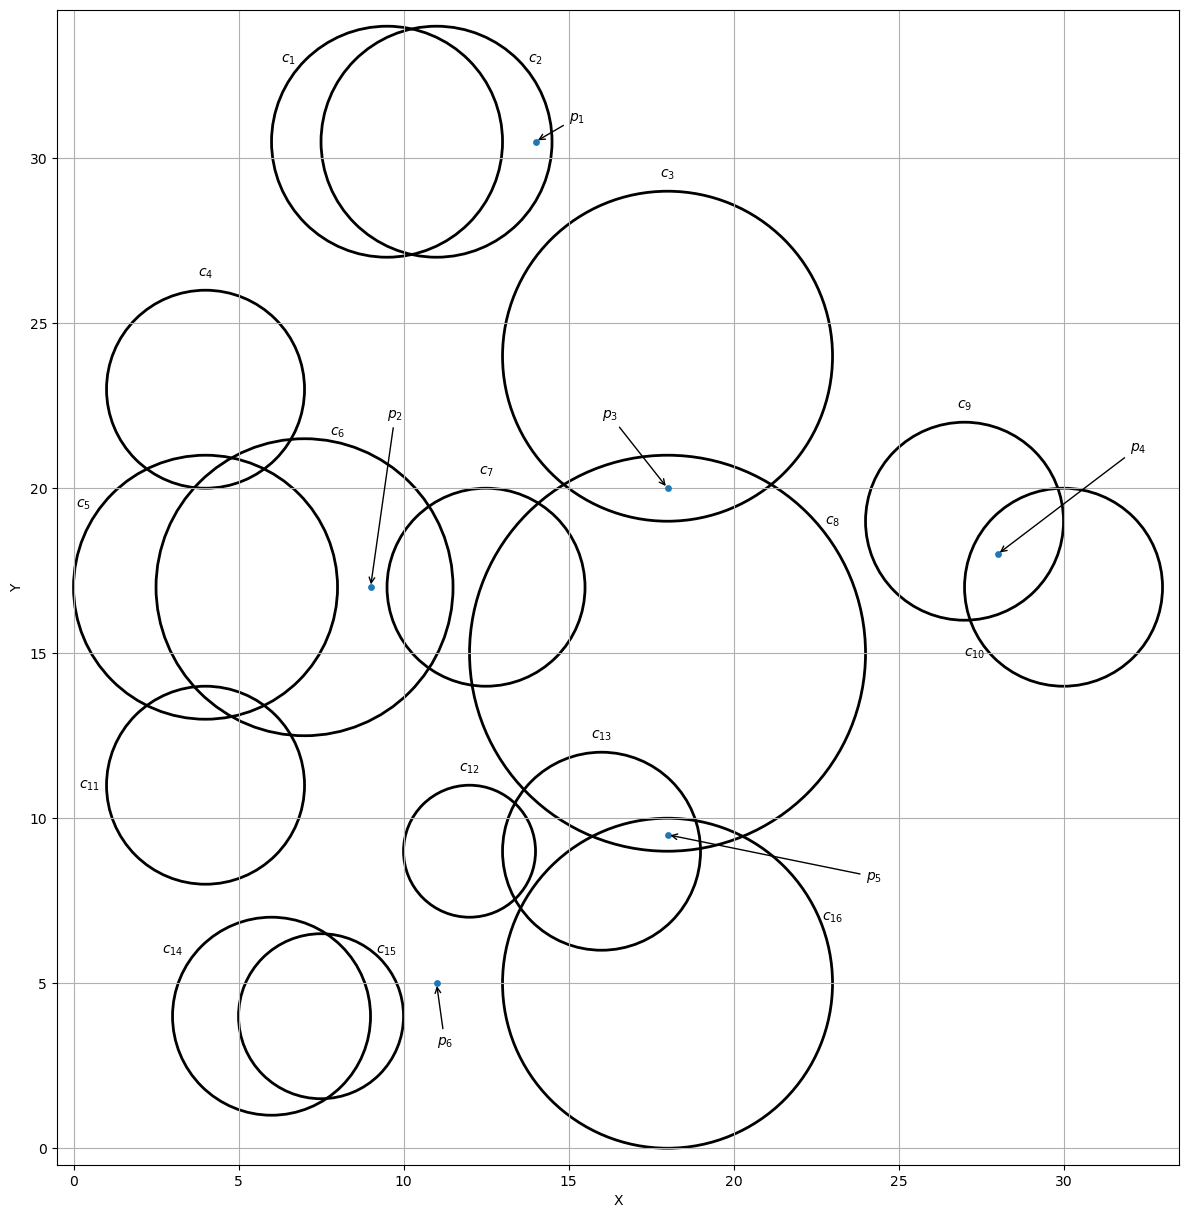

<Figure size 640x480 with 0 Axes>

In [4]:
annotations = [
    # {"anchor": "circle", "index": 9, "text": "Main cluster"},            # at circle center
    # {"anchor": "point",  "index": 1, "text": "Depot", "pos": (8.2, 17.8)},# offset with arrow
    {"anchor": "xy", "xy": (6.5, 33), "text": "$c_1$"},             # arbitrary location
    {"anchor": "xy", "xy": (14, 33), "text": "$c_2$"},             # arbitrary location
    {"anchor": "xy", "xy": (18, 29.5), "text": "$c_3$"},             # arbitrary location
    {"anchor": "xy", "xy": (4, 26.5), "text": "$c_4$"},             # arbitrary location
    {"anchor": "xy", "xy": (0.3, 19.5), "text": "$c_5$"},             # arbitrary location
    {"anchor": "xy", "xy": (8, 21.7), "text": "$c_6$"},             # arbitrary location
    {"anchor": "xy", "xy": (12.5, 20.5), "text": "$c_7$"},             # arbitrary location
    {"anchor": "xy", "xy": (23, 19), "text": "$c_8$"},             # arbitrary location
    {"anchor": "xy", "xy": (27, 22.5), "text": "$c_9$"},             # arbitrary location
    {"anchor": "xy", "xy": (27.3, 15), "text": "$c_{10}$"},             # arbitrary location
    {"anchor": "xy", "xy": (0.5, 11), "text": "$c_{11}$"},             # arbitrary location
    {"anchor": "xy", "xy": (12, 11.5), "text": "$c_{12}$"},             # arbitrary location
    {"anchor": "xy", "xy": (16, 12.5), "text": "$c_{13}$"},             # arbitrary location
    {"anchor": "xy", "xy": (3, 6), "text": "$c_{14}$"},             # arbitrary location
    {"anchor": "xy", "xy": (9.5, 6), "text": "$c_{15}$"},             # arbitrary location
    {"anchor": "xy", "xy": (23, 7), "text": "$c_{16}$"},             # arbitrary location

    {"anchor": "point",  "index": 1, "text": "$p_2$", "pos": (9.5, 22)},# offset with arrow
    {"anchor": "point",  "index": 2, "text": "$p_5$", "pos": (24, 8)},# offset with arrow
    {"anchor": "point",  "index": 3, "text": "$p_3$", "pos": (16, 22)},# offset with arrow
    {"anchor": "point",  "index": 4, "text": "$p_6$", "pos": (11, 3)},# offset with arrow
    {"anchor": "point",  "index": 5, "text": "$p_1$", "pos": (15, 31)},# offset with arrow
    {"anchor": "point",  "index": 0, "text": "$p_4$", "pos": (32, 21)},# offset with arrow
    # {"anchor": "circle", "index": 3, "text": "North hub","pos": (3.6, 18.6), "arrow": True, "style": {"fontsize": 9}}
]

plot_circles_points(
    circles=circles,
    points=points,
    annotations=annotations,
    show_vline=False,   # optional vertical line
    vline_x=1,
    title=""
)

plt.savefig("figure.png", dpi=300, bbox_inches="tight")   # for copy/paste & slides

# plt.savefig("../Images/my_plot.svg")
# tikzplotlib.save("../Images/figure.tex") 

Para la figura:

$C =\{c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9, c_{10}, c_{11}, c_{12}, c_{13}, c_{14}, c_{15}, c_{16} \}$

$P =\{p_1, p_2, p_3, p_4, p_5, p_6 \}$

## Observación 2.1
Un arreglo de *n* círculos divide al plano en un conjunto de regiones *R*, con máximo $O(n^2)$ regiones.


Para nuestro ejemplo $n=16$, por lo tanto $n^2=256$

Y hay 35 regiones

In [5]:
16**2

256

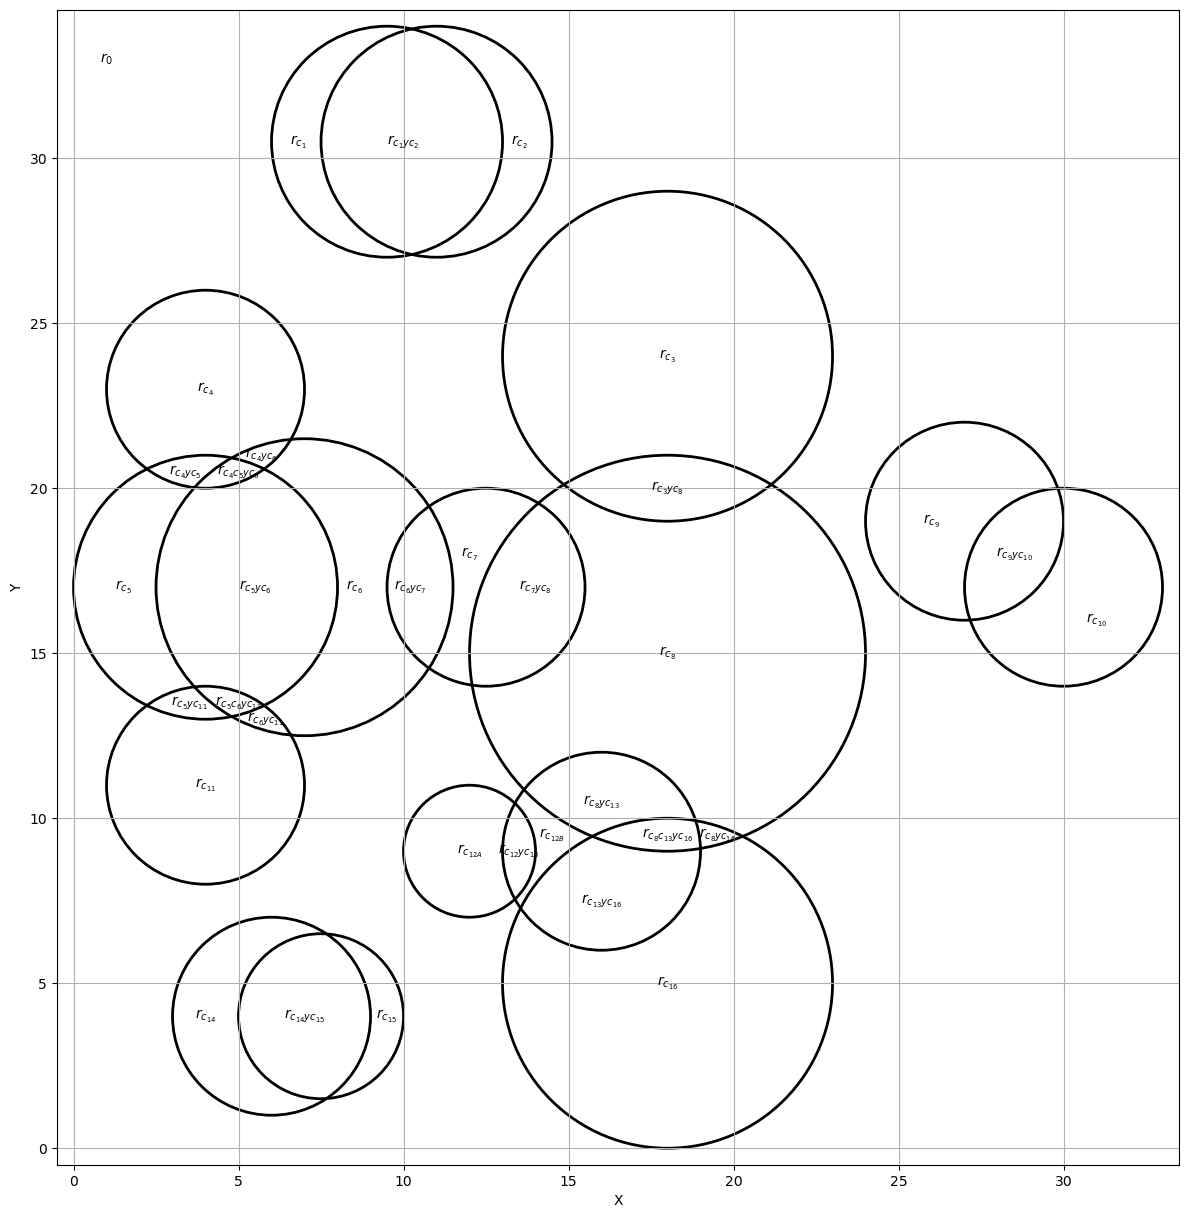

(<Figure size 1500x1500 with 1 Axes>, <Axes: xlabel='X', ylabel='Y'>)

In [21]:
annotations = [
    # {"anchor": "circle", "index": 9, "text": "Main cluster"},            # at circle center
    # {"anchor": "point",  "index": 1, "text": "Depot", "pos": (8.2, 17.8)},# offset with arrow
    {"anchor": "xy", "xy": (1, 33), "text": "$r_0$"},             # arbitrary location
    {"anchor": "xy", "xy": (6.8, 30.5), "text": "$r_{c_1}$"},             # arbitrary location
    {"anchor": "xy", "xy": (10, 30.5), "text": "$r_{c_1yc_2}$"},             # arbitrary location
    {"anchor": "xy", "xy": (13.5, 30.5), "text": "$r_{c_2}$"},             # arbitrary location
    {"anchor": "xy", "xy": (4, 23), "text": "$r_{c_4}$"},             # arbitrary location
    {"anchor": "xy", "xy": (18, 24), "text": "$r_{c_3}$"},             # arbitrary location
    {"anchor": "xy", "xy": (3.4, 20.5), "text": "$r_{c_4yc_5}$"},             # arbitrary location
    {"anchor": "xy", "xy": (5., 20.5), "text": "$r_{c_4c_5yc_6}$"},             # arbitrary location
    {"anchor": "xy", "xy": (5.7, 21), "text": "$r_{c_4yc_6}$"},             # arbitrary location
    {"anchor": "xy", "xy": (1.5, 17), "text": "$r_{c_5}$"},             # arbitrary location
    {"anchor": "xy", "xy": (5.5, 17), "text": "$r_{{c_5yc_6}}$"},             # arbitrary location
    {"anchor": "xy", "xy": (8.5, 17), "text": "$r_{c_6}$"},             # arbitrary location
    {"anchor": "xy", "xy": (10.2, 17), "text": "$r_{c_6yc_7}$"},             # arbitrary location
    {"anchor": "xy", "xy": (12, 18), "text": "$r_{c_7}$"},             # arbitrary location
    {"anchor": "xy", "xy": (14, 17), "text": "$r_{c_7yc_8}$"},             # arbitrary location
    {"anchor": "xy", "xy": (18, 20), "text": "$r_{c_3yc_8}$"},             # arbitrary location
    {"anchor": "xy", "xy": (18, 15), "text": "$r_{c_8}$"},             # arbitrary location
    {"anchor": "xy", "xy": (26, 19), "text": "$r_{c_9}$"},             # arbitrary location
    {"anchor": "xy", "xy": (28.5, 18), "text": "$r_{c_9yc_{10}}$"},             # arbitrary location
    {"anchor": "xy", "xy": (31, 16), "text": "$r_{c_{10}}$"},             # arbitrary location
    {"anchor": "xy", "xy": (3.5, 13.5), "text": "$r_{c_5yc_{11}}$"},             # arbitrary location
    {"anchor": "xy", "xy": (5, 13.5), "text": "$r_{c_5c_6yc_{11}}$"},             # arbitrary location
    {"anchor": "xy", "xy": (5.8, 13), "text": "$r_{c_6yc_{11}}$"},             # arbitrary location
    {"anchor": "xy", "xy": (4, 11), "text": "$r_{c_{11}}$"},             # arbitrary location
    {"anchor": "xy", "xy": (12, 9), "text": "$r_{c_{12A}}$"},             # arbitrary location
    {"anchor": "xy", "xy": (13.5, 9), "text": "$r_{c_{12}yc_{13}}$"},             # arbitrary location
    {"anchor": "xy", "xy": (14.5, 9.5), "text": "$r_{c_{12B}}$"},             # arbitrary location
    {"anchor": "xy", "xy": (16, 10.5), "text": "$r_{c_8yc_{13}}$"},             # arbitrary location
    {"anchor": "xy", "xy": (16, 7.5), "text": "$r_{c_{13}yc_{16}}$"},             # arbitrary location
    {"anchor": "xy", "xy": (18, 9.5), "text": "$r_{c_8c_{13}yc_{16}}$"},             # arbitrary location
    {"anchor": "xy", "xy": (19.5, 9.5), "text": "$r_{c_8yc_{16}}$"},             # arbitrary location
    {"anchor": "xy", "xy": (18, 5), "text": "$r_{c_{16}}$"},             # arbitrary location
    {"anchor": "xy", "xy": (4, 4), "text": "$r_{c_{14}}$"},             # arbitrary location
    {"anchor": "xy", "xy": (7, 4), "text": "$r_{c_{14}yc_{15}}$"},             # arbitrary location
    {"anchor": "xy", "xy": (9.5, 4), "text": "$r_{c_{15}}$"},             # arbitrary location

    # {"anchor": "xy", "xy": (6.5, 33), "text": "$c_1$"},             # arbitrary location
    # {"anchor": "xy", "xy": (14, 33), "text": "$c_2$"},             # arbitrary location
    # {"anchor": "xy", "xy": (18, 29.5), "text": "$c_3$"},             # arbitrary location
    # {"anchor": "xy", "xy": (4, 26.5), "text": "$c_4$"},             # arbitrary location
    # {"anchor": "xy", "xy": (0.3, 19.5), "text": "$c_5$"},             # arbitrary location
    # {"anchor": "xy", "xy": (8, 21.7), "text": "$c_6$"},             # arbitrary location
    # {"anchor": "xy", "xy": (12.5, 20.5), "text": "$c_7$"},             # arbitrary location
    # {"anchor": "xy", "xy": (23, 19), "text": "$c_8$"},             # arbitrary location
    # {"anchor": "xy", "xy": (27, 22.5), "text": "$c_9$"},             # arbitrary location
    # {"anchor": "xy", "xy": (27.3, 15), "text": "$c_{10}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (0.5, 11), "text": "$c_{11}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (12, 11.5), "text": "$c_{12}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (16, 12.5), "text": "$c_{13}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (3, 6), "text": "$c_{14}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (9.5, 6), "text": "$c_{15}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (23, 7), "text": "$c_{16}$"},             # arbitrary location


    # {"anchor": "point",  "index": 1, "text": "$p_2$", "pos": (9, 21)},# offset with arrow
    # {"anchor": "point",  "index": 2, "text": "$p_5$", "pos": (24, 8)},# offset with arrow
    # {"anchor": "point",  "index": 3, "text": "$p_3$", "pos": (23, 21)},# offset with arrow
    # {"anchor": "point",  "index": 4, "text": "$p_6$", "pos": (11, 3)},# offset with arrow
    # {"anchor": "point",  "index": 5, "text": "$p_1$", "pos": (15, 31)},# offset with arrow
    # {"anchor": "point",  "index": 0, "text": "$p_4$", "pos": (32, 21)},# offset with arrow
    # {"anchor": "circle", "index": 3, "text": "North hub","pos": (3.6, 18.6), "arrow": True, "style": {"fontsize": 9}}
]

plot_circles_points(
    circles=circles,
    # points=points,
    annotations=annotations,
    show_vline=False,   # optional vertical line
    vline_x=1,
    title=""
)

Con esta dos figuras podemos obtener $C_r$ para cada región

Para cada región $r$ llamamos $C_r$ al conjunto de círculos activos que contienen esa región.

| Región | Círculos con esa región          |
|:------:|:--------------------------------:|
| 1      | $\emptyset$                      |
| 2      | $C_r = \{ c_1 \}$                |
| 3      | $C_r = \{ c_1, c_2 \}$           |
| 4      | $C_r = \{ c_2 \}$                |
| 5      | $C_r = \{ c_4 \}$                |
| 6      | $C_r = \{ c_3 \}$                |
| 7      | $C_r = \{ c_4, c_5 \}$           |
| 8      | $C_r = \{ c_4, c_5, c_6 \}$      |
| 9      | $C_r = \{ c_4, c_6 \}$           |
| 10     | $C_r = \{ c_5 \}$                |
| 11     | $C_r = \{ c_5, c_6 \}$           |
| 12     | $C_r = \{ c_6 \}$                |
| 13     | $C_r = \{ c_6, c_7 \}$           |
| 14     | $C_r = \{ c_7 \}$                |
| 15     | $C_r = \{ c_7, c_8 \}$           |
| 16     | $C_r = \{ c_3, c_8 \}$           |
| 17     | $C_r = \{ c_8 \}$                |
| 18     | $C_r = \{ c_9 \}$                |
| 19     | $C_r = \{ c_9, c_{10} \}$        |
| 20     | $C_r = \{ c_{10} \}$             |
| 21     | $C_r = \{ c_5, c_{11} \}$        |
| 22     | $C_r = \{ c_5, c_6, c_{11} \}$   |
| 23     | $C_r = \{ c_6, c_{11} \}$        |
| 24     | $C_r = \{ c_{11} \}$             |
| 25     | $C_r = \{ c_{12} \}$             |
| 26     | $C_r = \{ c_{12}, c_{13} \}$     |
| 27     | $C_r = \{ c_{13} \}$             |
| 28     | $C_r = \{ c_{8}, c_{13} \}$      |
| 29     | $C_r = \{ c_{13}, c_{16} \}$     |
| 30     | $C_r = \{ c_8, c_{13}, c_{16} \}$|
| 31     | $C_r = \{ c_8, c_{16} \}$        |
| 32     | $C_r = \{ c_{16} \}$             |
| 33     | $C_r = \{ c_{14} \}$             |
| 34     | $C_r = \{ c_{14}, c_{15} \}$     |
| 35     | $C_r = \{ c_{15} \}$             |


### Observación 2.2

Si un círculo no está vacío, entonces es suficiente con encontrar un *testigo* (esto es, un punto dentro del círculo) para eliminarlo de la lista de círculos vacíos ("podarlo")

### Observación 2.3
Si un punto está en la región $r \in R$, entonces todos los círculos que contienen esta región no están vacíos, y pueden ser "podados".

## Algoritmo

### Definiciones

**Relación de orden parcial**

Para cada posición de la línea de barrido, definimos una **relación de orden parcial** $<_a$, en el conjunto de regiones $R$ de la siguiente forma:
Para dos regiones $r_i$ y $r_j$ en $R$, se dice que $r_i <_a r_j$ si la intersección de la región $r_i$ con la línea vertical $x=a$ cae debajo de la intersección de la región $r_j$ con la misma línea.

Este órden de información se mantiene en el *Estado de la Línea de barrido* denominado $\mathcal{L}$

**Punto de evento**

Un **punto de evento** puede ser el punto de interseción de dos círculos, o el punto más a la izquierda o más a la derecha de un círculo, o un punto de entrada.

**Orden de prioridad**

Los eventos se mantienen en una lista de prioridad $Q$, que al inicio del algoritmo contiene los puntos de entrada y los puntos más a la izquierda de cada círculo.

**Círculo activo**

A un círculo $C$ se le dice que está "activo" si está vacío o aún no se ha encontrado ningún testigo en él.

Al conjunto de círculos activos lo denotamos con $A_c$.

Inicialmente $A_c = C$

# Ejemplo paso a paso

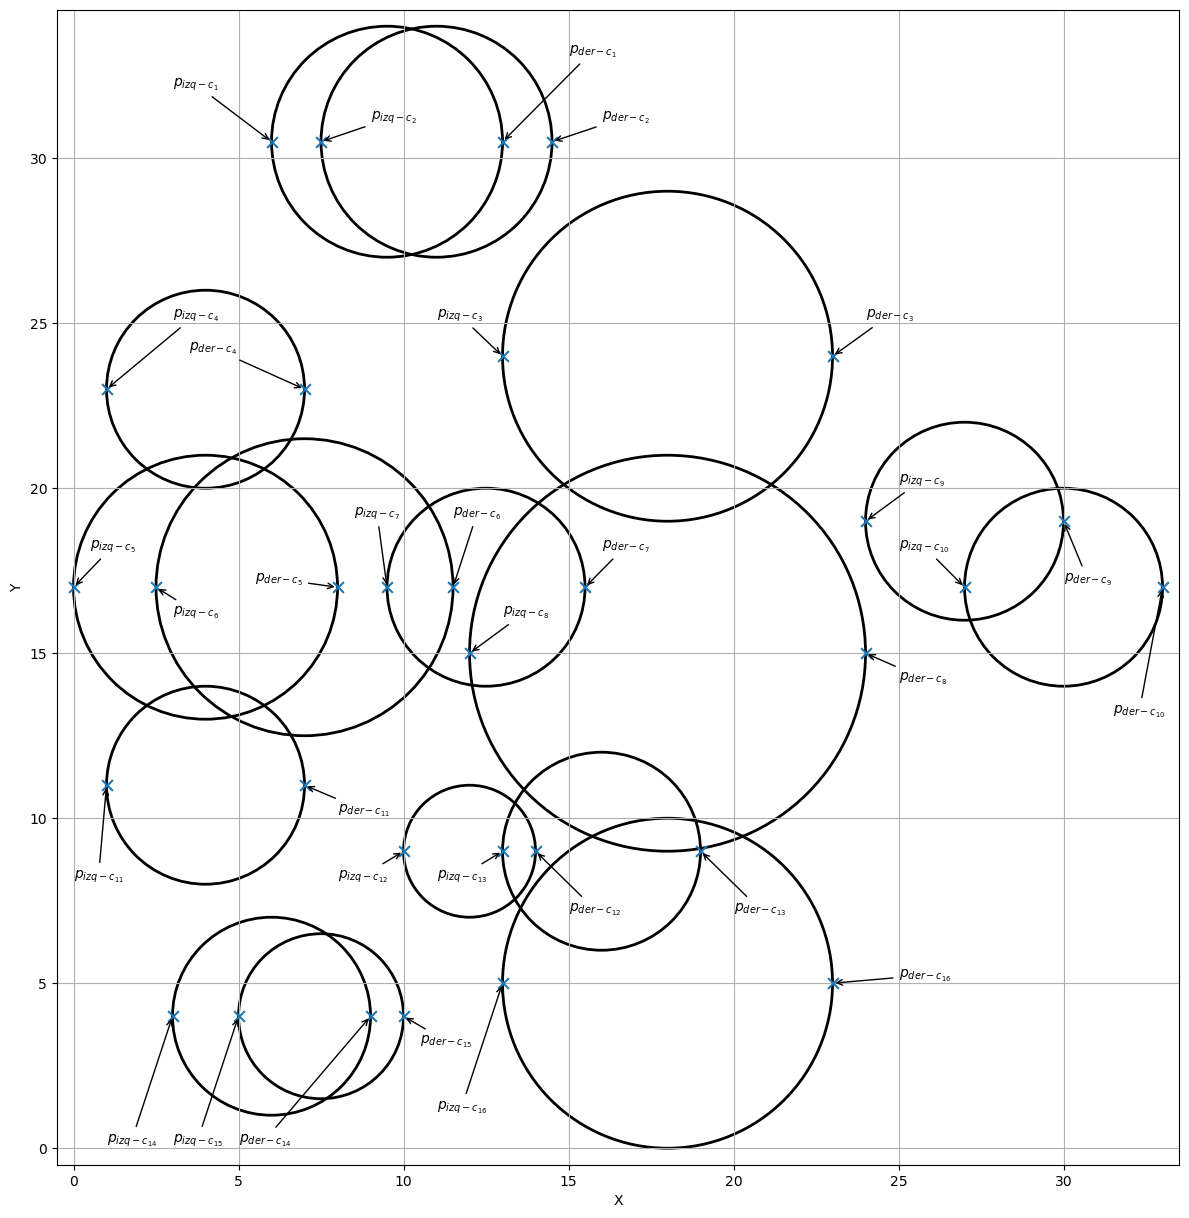

(<Figure size 1500x1500 with 1 Axes>, <Axes: xlabel='X', ylabel='Y'>)

In [25]:
# circles = [
#     ((7.5, 4), 2.5),
#     ((6, 4),  3),
#     ((4, 11), 3),
#     ((4, 17), 4),
#     ((4, 23), 3),
#     ((7, 17), 4.5),
#     ((9.5, 30.5), 3.5),
#     ((11, 30.5), 3.5),
#     ((18, 5), 5),
#     ((18, 15), 6),
#     ((18, 24), 5),
#     ((12, 9), 2),
#     ((12.5,17), 3),
#     ((16,9),3),
#     ((27,19),3),
#     ((30,17),3)
# ]

points = [
    # (28, 18),           # p4
    # (9, 17),            # p2
    # (18, 9.5),          # p5
    # (18, 20),           # p3
    # (11, 5),            # p6
    # (14, 30.5),         # p1
    (7.5-2.5, 4),       # p c15
    (6-3, 4),           # p c14
    (4-3, 11),          # p c11
    (4-4, 17),          # p c5
    (4-3, 23),          # p c4
    (7-4.5, 17),        # p c6
    (9.5-3.5, 30.5),    # p c1
    (11-3.5, 30.5),     # p c2
    (18-5, 5),          # p c16
    (18-6, 15),         # p c8
    (18-5, 24),         # p c3
    (12-2, 9),          # p c12
    (12.5-3,17),        # p c7
    (16-3,9),           # p c13
    (27-3,19),          # p c9
    (30-3,17),          # p c10
    
    (7.5+2.5, 4),       # p c15
    (6+3, 4),           # p c14
    (4+3, 11),          # p c11
    (4+4, 17),          # p c5
    (4+3, 23),          # p c4
    (7+4.5, 17),        # p c6
    (9.5+3.5, 30.5),    # p c1
    (11+3.5, 30.5),     # p c2
    (18+5, 5),          # p c16
    (18+6, 15),         # p c8
    (18+5, 24),         # p c3
    (12+2, 9),          # p c12
    (12.5+3,17),        # p c7
    (16+3,9),           # p c13
    (27+3,19),          # p c9
    (30+3,17),          # p c10
]

annotations = [
    # {"anchor": "circle", "index": 9, "text": "Main cluster"},            # at circle center
    # {"anchor": "point",  "index": 1, "text": "Depot", "pos": (8.2, 17.8)},# offset with arrow
    # {"anchor": "xy", "xy": (6.5, 33), "text": "$c_1$"},             # arbitrary location
    # {"anchor": "xy", "xy": (14, 33), "text": "$c_2$"},             # arbitrary location
    # {"anchor": "xy", "xy": (18, 29.5), "text": "$c_3$"},             # arbitrary location
    # {"anchor": "xy", "xy": (4, 26.5), "text": "$c_4$"},             # arbitrary location
    # {"anchor": "xy", "xy": (0.3, 19.5), "text": "$c_5$"},             # arbitrary location
    # {"anchor": "xy", "xy": (8, 21.7), "text": "$c_6$"},             # arbitrary location
    # {"anchor": "xy", "xy": (12.5, 20.5), "text": "$c_7$"},             # arbitrary location
    # {"anchor": "xy", "xy": (23, 19), "text": "$c_8$"},             # arbitrary location
    # {"anchor": "xy", "xy": (27, 22.5), "text": "$c_9$"},             # arbitrary location
    # {"anchor": "xy", "xy": (27.3, 15), "text": "$c_{10}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (0.5, 11), "text": "$c_{11}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (12, 11.5), "text": "$c_{12}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (16, 12.5), "text": "$c_{13}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (3, 6), "text": "$c_{14}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (9.5, 6), "text": "$c_{15}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (23, 7), "text": "$c_{16}$"},             # arbitrary location

    # {"anchor": "point",  "index": 1, "text": "$p_2$", "pos": (8.5, 16)},# offset with arrow
    # {"anchor": "point",  "index": 2, "text": "$p_5$", "pos": (24, 8)},# offset with arrow
    # {"anchor": "point",  "index": 3, "text": "$p_3$", "pos": (19, 22)},# offset with arrow
    # {"anchor": "point",  "index": 4, "text": "$p_6$", "pos": (11.5, 4)},# offset with arrow
    # {"anchor": "point",  "index": 5, "text": "$p_1$", "pos": (15.5, 32)},# offset with arrow
    # {"anchor": "point",  "index": 0, "text": "$p_4$", "pos": (29, 18)},# offset with arrow

    
    {"anchor": "point",  "index": 0, "text": "$p_{izq-c_{15}}$", "pos": (3, 0)},# offset with arrow
    {"anchor": "point",  "index": 1, "text": "$p_{izq-c_{14}}$", "pos": (1, 0)},# offset with arrow
    {"anchor": "point",  "index": 2, "text": "$p_{izq-c_{11}}$", "pos": (0, 8)},# offset with arrow
    {"anchor": "point",  "index": 3, "text": "$p_{izq-c_{5}}$", "pos": (0.5, 18)},# offset with arrow
    {"anchor": "point",  "index": 4, "text": "$p_{izq-c_{4}}$", "pos": (3, 25)},# offset with arrow
    {"anchor": "point",  "index": 5, "text": "$p_{izq-c_{6}}$", "pos": (3, 16)},# offset with arrow
    {"anchor": "point",  "index": 6, "text": "$p_{izq-c_{1}}$", "pos": (3, 32)},# offset with arrow
    {"anchor": "point",  "index": 7, "text": "$p_{izq-c_{2}}$", "pos": (9, 31)},# offset with arrow
    {"anchor": "point",  "index": 8, "text": "$p_{izq-c_{16}}$", "pos": (11, 1)},# offset with arrow
    {"anchor": "point",  "index": 9, "text": "$p_{izq-c_{8}}$", "pos": (13, 16)},# offset with arrow
    {"anchor": "point",  "index": 10, "text": "$p_{izq-c_{3}}$", "pos": (11, 25)},# offset with arrow
    {"anchor": "point",  "index": 11, "text": "$p_{izq-c_{12}}$", "pos": (8, 8)},# offset with arrow
    {"anchor": "point",  "index": 12, "text": "$p_{izq-c_{7}}$", "pos": (8.5, 19)},# offset with arrow.
    {"anchor": "point",  "index": 13, "text": "$p_{izq-c_{13}}$", "pos": (11, 8)},# offset with arrow
    {"anchor": "point",  "index": 14, "text": "$p_{izq-c_{9}}$", "pos": (25, 20)},# offset with arrow
    {"anchor": "point",  "index": 15, "text": "$p_{izq-c_{10}}$", "pos": (25, 18)},# offset with arrow

    {"anchor": "point",  "index": 16, "text": "$p_{der-c_{15}}$", "pos": (10.5, 3)},# offset with arrow
    {"anchor": "point",  "index": 17, "text": "$p_{der-c_{14}}$", "pos": (5, 0)},# offset with arrow
    {"anchor": "point",  "index": 18, "text": "$p_{der-c_{11}}$", "pos": (8, 10)},# offset with arrow
    {"anchor": "point",  "index": 19, "text": "$p_{der-c_{5}}$", "pos": (5.5, 17)},# offset with arrow
    {"anchor": "point",  "index": 20, "text": "$p_{der-c_{4}}$", "pos": (3.5, 24)},# offset with arrow
    {"anchor": "point",  "index": 21, "text": "$p_{der-c_{6}}$", "pos": (11.5, 19)},# offset with arrow
    {"anchor": "point",  "index": 22, "text": "$p_{der-c_{1}}$", "pos": (15, 33)},# offset with arrow
    {"anchor": "point",  "index": 23, "text": "$p_{der-c_{2}}$", "pos": (16., 31)},# offset with arrow
    {"anchor": "point",  "index": 24, "text": "$p_{der-c_{16}}$", "pos": (25, 5)},# offset with arrow
    {"anchor": "point",  "index": 25, "text": "$p_{der-c_{8}}$", "pos": (25, 14)},# offset with arrow
    {"anchor": "point",  "index": 26, "text": "$p_{der-c_{3}}$", "pos": (24, 25)},# offset with arrow
    {"anchor": "point",  "index": 27, "text": "$p_{der-c_{12}}$", "pos": (15, 7)},# offset with arrow
    {"anchor": "point",  "index": 28, "text": "$p_{der-c_{7}}$", "pos": (16, 18)},# offset with arrow.
    {"anchor": "point",  "index": 29, "text": "$p_{der-c_{13}}$", "pos": (20, 7)},# offset with arrow
    {"anchor": "point",  "index": 30, "text": "$p_{der-c_{9}}$", "pos": (30, 17)},# offset with arrow
    {"anchor": "point",  "index": 31, "text": "$p_{der-c_{10}}$", "pos": (31.5, 13)},# offset with arrow
    
    # {"anchor": "circle", "index": 3, "text": "North hub","pos": (3.6, 18.6), "arrow": True, "style": {"fontsize": 9}}
]


plot_circles_points(
    circles=circles,
    points=points,
    annotations=annotations,
    show_vline=False,   # optional vertical line
    vline_x=0,
    title="",
    marker = "x"
)

Del gráfico vemos que $Q$ inicial es:

$Q = \{ p_{izq-c_{5}}, p_{izq-c_{11}}, p_{izq-c_{4}}, p_{izq-c_{6}}, p_{izq-c_{14}}, p_{izq-c_{15}}, p_{izq-c_{1}}, p_{izq-c_{2}}, p_{2}, p_{izq-c_{7}}, p_{izq-c_{12}}, p_{6}, p_{izq-c_{8}}, p_{izq-c_{16}}, p_{izq-c_{13}}, p_{izq-c_{3}}, p_1, p_5, p_3, p_{izq-c_{9}}, p_{izq-c_{10}}, p_4  \}$

$Q = \{ (0, 17), (1, 11), (1, 23), (2.5, 17), (3, 4), (5, 4), (6, 30.5), (7.5, 30.5), (9, 17), (9.5, 17), (10, 9), (11, 5), (12, 15), (13, 5), (13, 9), (13, 24), (14, 30.5), (18, 9.5), (18, 20), (24, 19), (27, 17), (28,1 8) \}$

$A_c=C$

## Paso 1

| Algoritmo de punto tangente izquierdo                                                         | Ejemplo |
|:--------------------------------------------------------------------------------------------- | :-----------------------|
| Sea $e \in Q$ el punto izquierdo tangente a la línea $\mathcal{L}$ del círculo $c \in A_C$    | $e=(0,17)=p_{izq-c_3}$  |
|Incertamos en Q el punto del círculo $c$ tangente a $\mathcal{L}$ del lado derecho             | $Q \cup \{ (8,17)\}$    |
|$r =$ la región en $\mathcal{L}$ que contiene a $e$                                            | $r = r_1$               |
|$r_{i}=$ la región arriba de $c$ de $r$                                                        | $r_{i} = r_1 $          |
|$r_{ii}=$ la región en $c$ de $r$                                                              | $r_{ii}= r_{10}$        |
|$r_{iii}=$ la región debajo de $c$ de $r$                                                      | $r_{i} = r_1 $          |
|Quitar $r$ de $\mathcal{L}$.                                                                   | $\mathcal{L}$|
|Insertar $r_1$, $r_2$, $r_3$ en $\mathcal{L}$                                                  ||
|$C_{r_i} = C_{r_{iii}} = C_r$                                                                         ||
|$C_{r_{ii}} = C_r \cup \{c\}$                                                                         ||
|Si $c$ intersecta el arco circular que limita por arriba a $r_1$, entonces inserta este punto de intersección en $Q$||
|Si $c$ intersecta el arco circular que limita por abajo a $r_3$, entonces inserta este punto de intersección en $Q$||
|Fin|


In [8]:
# --- Data ---
circles = [
    ((7.5, 4), 2.5),
    ((6, 4),  3),
    ((4, 11), 3),
    ((4, 17), 4),
    ((4, 23), 3),
    ((7, 17), 4.5),
    ((9.5, 30.5), 3.5),
    ((11, 30.5), 3.5),
    ((18, 5), 5),
    ((18, 15), 6),
    ((18, 24), 5),
    ((12, 9), 2),
    ((12.5,17), 3),
    ((16,9),3),
    ((27,19),3),
    ((30,17),3)
]

points = [
    (28, 18), 
    (9, 17), 
    (18, 9.5), 
    (18, 20), 
    (11, 5), 
    (14, 30.5)
]


In [9]:
def build_Q(circles, points):
    Q = []

    # Add left-end-points from circles
    for (x, y), r in circles:
        Q.append((x - r, y, "left-end-point"))

    # Add input-points from points
    for (x, y) in points:
        Q.append((x, y, "input-point"))

    # Sort: first by x, then by y
    Q_sorted = sorted(Q, key=lambda p: (p[0], p[1]))

    return Q_sorted
    
#######################################################

def circles_containing_point(circles, point):
    """
    Return a list of circles that contain the given point.
    
    circles: list of ((cx, cy), r)
    point: (x, y, label) or (x, y)
    """
    # unpack (ignore label if present)
    if len(point) == 3:
        x, y, _ = point
    else:
        x, y = point
    
    inside = []
    for circle in circles:
        (cx, cy), r = circle
        dist_sq = (x - cx)**2 + (y - cy)**2
        if dist_sq <= r**2:  # inside or on boundary
            inside.append(circle)
    return inside


In [10]:
def n_circles_m_points(circles, points, return_removed=False):
    Q = build_Q(circles, points)   # assumes you already have this
    Ac = list(circles)             # work on a copy so original isn't mutated
    removed = []                   # track removed circles if you want
    print(Q)
    for x, y, ptype in Q:
        if ptype == "left-end-point":
            print("Left",x,y)
        elif ptype == "input-point":
            print("Input",x,y)
            point = (x, y, ptype)
            inside = circles_containing_point(Ac, point)
            print(inside)  # optional: show which circles contain this point

            if inside:
                # remove all circles that contain the input point
                Ac = [c for c in Ac if c not in inside]
                print ("Ac", Ac)
                removed.extend(inside)

        elif ptype == "right-end-point":
            print("Right")
        elif ptype == "intersection-point":
            print("Intersection")
        else:
            print("O", end="")
    print()  # newline

    return (Ac, removed) if return_removed else Ac


    
n_circles_m_points(circles, points)

[(0, 17, 'left-end-point'), (1, 11, 'left-end-point'), (1, 23, 'left-end-point'), (2.5, 17, 'left-end-point'), (3, 4, 'left-end-point'), (5.0, 4, 'left-end-point'), (6.0, 30.5, 'left-end-point'), (7.5, 30.5, 'left-end-point'), (9, 17, 'input-point'), (9.5, 17, 'left-end-point'), (10, 9, 'left-end-point'), (11, 5, 'input-point'), (12, 15, 'left-end-point'), (13, 5, 'left-end-point'), (13, 9, 'left-end-point'), (13, 24, 'left-end-point'), (14, 30.5, 'input-point'), (18, 9.5, 'input-point'), (18, 20, 'input-point'), (24, 19, 'left-end-point'), (27, 17, 'left-end-point'), (28, 18, 'input-point')]
Left 0 17
Left 1 11
Left 1 23
Left 2.5 17
Left 3 4
Left 5.0 4
Left 6.0 30.5
Left 7.5 30.5
Input 9 17
[((7, 17), 4.5)]
Ac [((7.5, 4), 2.5), ((6, 4), 3), ((4, 11), 3), ((4, 17), 4), ((4, 23), 3), ((9.5, 30.5), 3.5), ((11, 30.5), 3.5), ((18, 5), 5), ((18, 15), 6), ((18, 24), 5), ((12, 9), 2), ((12.5, 17), 3), ((16, 9), 3), ((27, 19), 3), ((30, 17), 3)]
Left 9.5 17
Left 10 9
Input 11 5
[]
Left 12 15
L

[((7.5, 4), 2.5),
 ((6, 4), 3),
 ((4, 11), 3),
 ((4, 17), 4),
 ((4, 23), 3),
 ((9.5, 30.5), 3.5),
 ((12, 9), 2),
 ((12.5, 17), 3)]

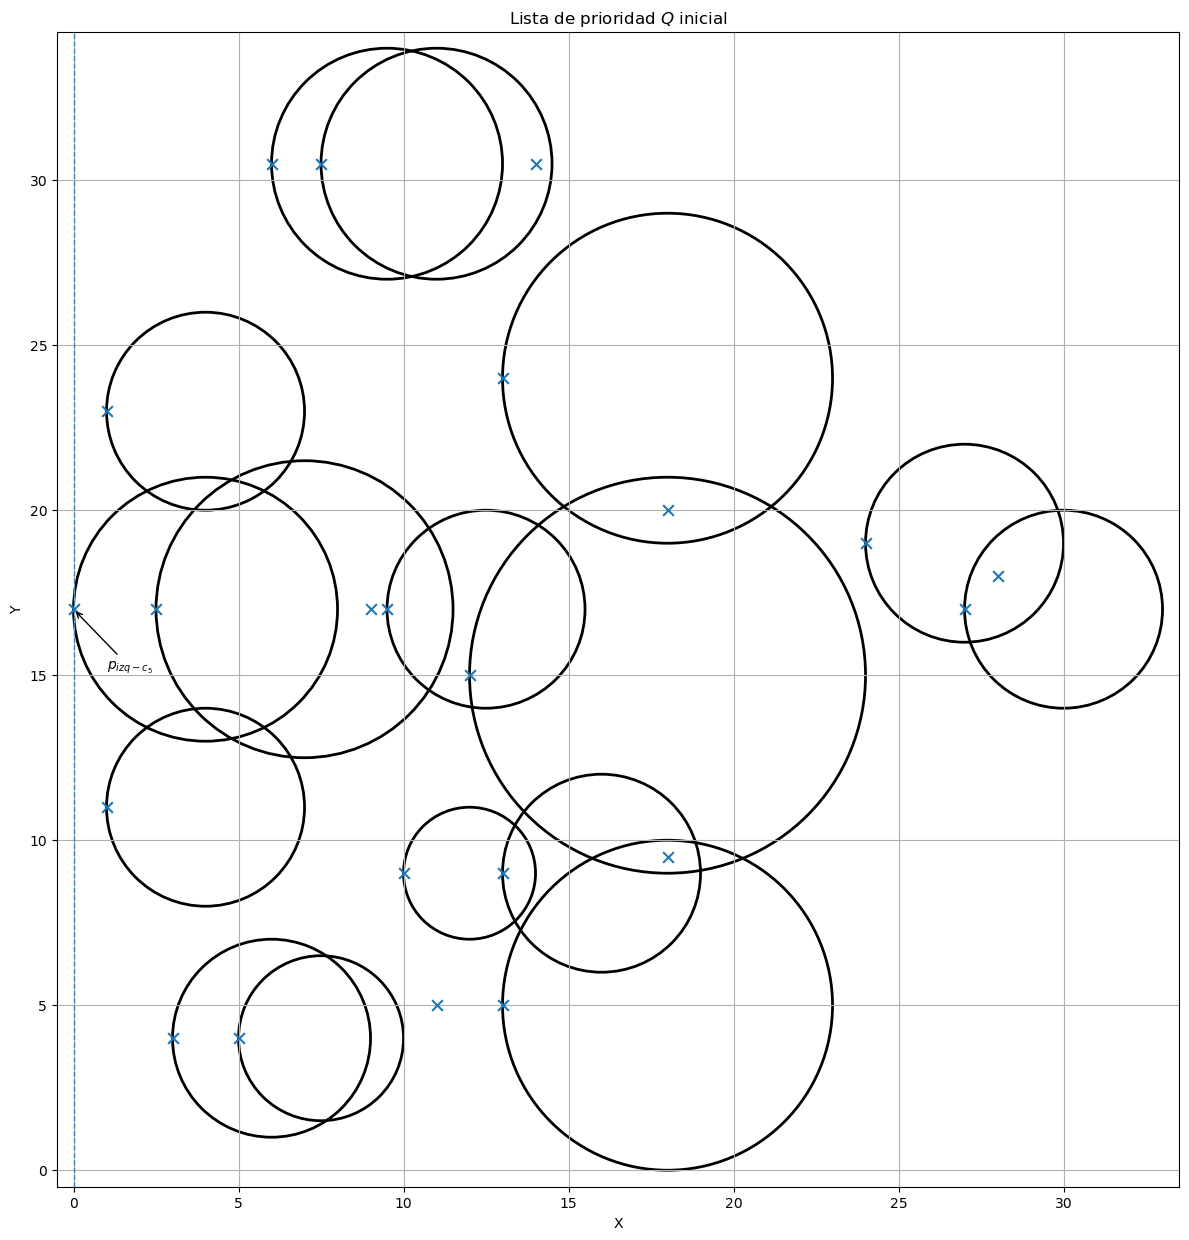

(<Figure size 1500x1500 with 1 Axes>,
 <Axes: title={'center': 'Lista de prioridad $Q$ inicial'}, xlabel='X', ylabel='Y'>)

In [11]:
# circles = [
#     ((7.5, 4), 2.5),
#     ((6, 4),  3),
#     ((4, 11), 3),
#     ((4, 17), 4),
#     ((4, 23), 3),
#     ((7, 17), 4.5),
#     ((9.5, 30.5), 3.5),
#     ((11, 30.5), 3.5),
#     ((18, 5), 5),
#     ((18, 15), 6),
#     ((18, 24), 5),
#     ((12, 9), 2),
#     ((12.5,17), 3),
#     ((16,9),3),
#     ((27,19),3),
#     ((30,17),3)
# ]

points = [
    (28, 18),           # p4
    (9, 17),            # p2
    (18, 9.5),          # p5
    (18, 20),           # p3
    (11, 5),            # p6
    (14, 30.5),         # p1
    (7.5-2.5, 4),       # p c15
    (6-3, 4),           # p c14
    (4-3, 11),          # p c11
    (4-4, 17),          # p c5
    (4-3, 23),          # p c4
    (7-4.5, 17),        # p c6
    (9.5-3.5, 30.5),    # p c1
    (11-3.5, 30.5),     # p c2
    (18-5, 5),          # p c16
    (18-6, 15),         # p c8
    (18-5, 24),         # p c3
    (12-2, 9),          # p c12
    (12.5-3,17),        # p c7
    (16-3,9),           # p c13
    (27-3,19),          # p c9
    (30-3,17),          # p c10
]

annotations = [
    # {"anchor": "circle", "index": 9, "text": "Main cluster"},            # at circle center
    # {"anchor": "point",  "index": 1, "text": "Depot", "pos": (8.2, 17.8)},# offset with arrow
    # {"anchor": "xy", "xy": (6.5, 33), "text": "$c_1$"},             # arbitrary location
    # {"anchor": "xy", "xy": (14, 33), "text": "$c_2$"},             # arbitrary location
    # {"anchor": "xy", "xy": (18, 29.5), "text": "$c_3$"},             # arbitrary location
    # {"anchor": "xy", "xy": (4, 26.5), "text": "$c_4$"},             # arbitrary location
    # {"anchor": "xy", "xy": (0.3, 19.5), "text": "$c_5$"},             # arbitrary location
    # {"anchor": "xy", "xy": (8, 21.7), "text": "$c_6$"},             # arbitrary location
    # {"anchor": "xy", "xy": (12.5, 20.5), "text": "$c_7$"},             # arbitrary location
    # {"anchor": "xy", "xy": (23, 19), "text": "$c_8$"},             # arbitrary location
    # {"anchor": "xy", "xy": (27, 22.5), "text": "$c_9$"},             # arbitrary location
    # {"anchor": "xy", "xy": (27.3, 15), "text": "$c_{10}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (0.5, 11), "text": "$c_{11}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (12, 11.5), "text": "$c_{12}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (16, 12.5), "text": "$c_{13}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (3, 6), "text": "$c_{14}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (9.5, 6), "text": "$c_{15}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (23, 7), "text": "$c_{16}$"},             # arbitrary location

    # {"anchor": "point",  "index": 1, "text": "$p_2$", "pos": (9.5, 22)},# offset with arrow
    # {"anchor": "point",  "index": 2, "text": "$p_5$", "pos": (24, 8)},# offset with arrow
    # {"anchor": "point",  "index": 3, "text": "$p_3$", "pos": (23, 21)},# offset with arrow
    # {"anchor": "point",  "index": 4, "text": "$p_6$", "pos": (11, 3)},# offset with arrow
    # {"anchor": "point",  "index": 5, "text": "$p_1$", "pos": (15, 31)},# offset with arrow
    # {"anchor": "point",  "index": 0, "text": "$p_4$", "pos": (32, 21)},# offset with arrow
    # {"anchor": "point",  "index": 6, "text": "$p_{izq-c_{15}}$", "pos": (7, 0)},# offset with arrow
    # {"anchor": "point",  "index": 7, "text": "$p_{izq-c_{14}}$", "pos": (3, 0)},# offset with arrow
    # {"anchor": "point",  "index": 8, "text": "$p_{izq-c_{11}}$", "pos": (3, 10)},# offset with arrow
    {"anchor": "point",  "index": 9, "text": "$p_{izq-c_{5}}$", "pos": (1, 15)},# offset with arrow
    # {"anchor": "point",  "index": 10, "text": "$p_{izq-c_{4}}$", "pos": (3, 23)},# offset with arrow
    # {"anchor": "point",  "index": 11, "text": "$p_{izq-c_{6}}$", "pos": (5, 15)},# offset with arrow
    # {"anchor": "point",  "index": 12, "text": "$p_{izq-c_{1}}$", "pos": (3, 32)},# offset with arrow
    # {"anchor": "point",  "index": 13, "text": "$p_{izq-c_{2}}$", "pos": (10, 32)},# offset with arrow
    # {"anchor": "point",  "index": 14, "text": "$p_{izq-c_{16}}$", "pos": (11, 1)},# offset with arrow
    # {"anchor": "point",  "index": 15, "text": "$p_{izq-c_{8}}$", "pos": (11, 12)},# offset with arrow
    # {"anchor": "point",  "index": 16, "text": "$p_{izq-c_{3}}$", "pos": (11, 25)},# offset with arrow
    # {"anchor": "point",  "index": 17, "text": "$p_{izq-c_{12}}$", "pos": (8, 8)},# offset with arrow
    # {"anchor": "point",  "index": 18, "text": "$p_{izq-c_{7}}$", "pos": (11, 21)},# offset with arrow.
    # {"anchor": "point",  "index": 19, "text": "$p_{izq-c_{13}}$", "pos": (11, 8)},# offset with arrow
    # {"anchor": "point",  "index": 20, "text": "$p_{izq-c_{9}}$", "pos": (25, 18)},# offset with arrow
    # {"anchor": "point",  "index": 21, "text": "$p_{izq-c_{10}}$", "pos": (25, 15)},# offset with arrow
    
    # {"anchor": "circle", "index": 3, "text": "North hub","pos": (3.6, 18.6), "arrow": True, "style": {"fontsize": 9}}
]


plot_circles_points(
    circles=circles,
    points=points,
    annotations=annotations,
    show_vline=True,   # optional vertical line
    vline_x=0,
    title="Lista de prioridad $Q$ inicial",
    marker = "x"
)

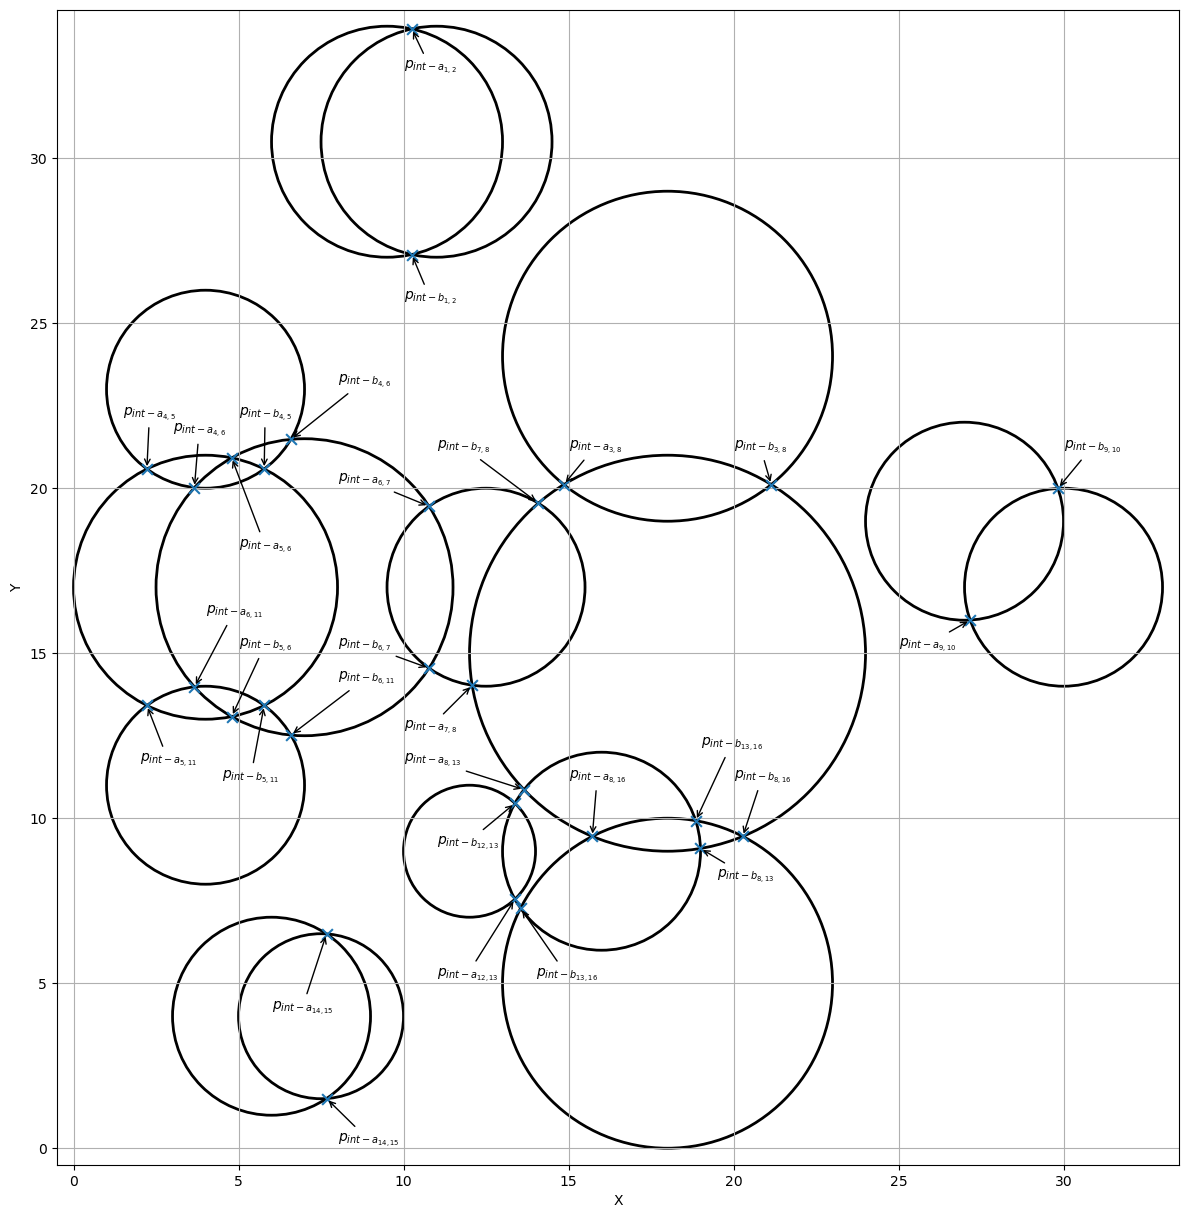

(<Figure size 1500x1500 with 1 Axes>, <Axes: xlabel='X', ylabel='Y'>)

In [124]:
# circles = [
#     ((7.5, 4), 2.5),
#     ((6, 4),  3),
#     ((4, 11), 3),
#     ((4, 17), 4),
#     ((4, 23), 3),
#     ((7, 17), 4.5),
#     ((9.5, 30.5), 3.5),
#     ((11, 30.5), 3.5),
#     ((18, 5), 5),
#     ((18, 15), 6),
#     ((18, 24), 5),
#     ((12, 9), 2),
#     ((12.5,17), 3),
#     ((16,9),3),
#     ((27,19),3),
#     ((30,17),3)
# ]

points = [
    # (28, 18),           # p4
    # (9, 17),            # p2
    # (18, 9.5),          # p5
    # (18, 20),           # p3
    # (11, 5),            # p6
    # (14, 30.5),         # p1
    # (7.5-2.5, 4),       # p c15
    # (6-3, 4),           # p c14
    # (4-3, 11),          # p c11
    # (4-4, 17),          # p c5
    # (4-3, 23),          # p c4
    # (7-4.5, 17),        # p c6
    # (9.5-3.5, 30.5),    # p c1
    # (11-3.5, 30.5),     # p c2
    # (18-5, 5),          # p c16
    # (18-6, 15),         # p c8
    # (18-5, 24),         # p c3
    # (12-2, 9),          # p c12
    # (12.5-3,17),        # p c7
    # (16-3,9),           # p c13
    # (27-3,19),          # p c9
    # (30-3,17),          # p c10
    
    # (7.5+2.5, 4),       # p c15
    # (6+3, 4),           # p c14
    # (4+3, 11),          # p c11
    # (4+4, 17),          # p c5
    # (4+3, 23),          # p c4
    # (7+4.5, 17),        # p c6
    # (9.5+3.5, 30.5),    # p c1
    # (11+3.5, 30.5),     # p c2
    # (18+5, 5),          # p c16
    # (18+6, 15),         # p c8
    # (18+5, 24),         # p c3
    # (12+2, 9),          # p c12
    # (12.5+3,17),        # p c7
    # (16+3,9),           # p c13
    # (27+3,19),          # p c9
    # (30+3,17),          # p c10

    (10.2500, 27.0813),  #1y2
    (10.2500, 33.9187),  #1y2
    (14.8573, 20.1111),  #3y8
    (21.1427, 20.1111),  #3y8
    (2.2224, 20.5833),    #4y5
    (5.7776, 20.5833),   #4y5
    (3.6630, 20.0190),   #4y6
    (6.5870, 21.4810),   #4y6
    (4.7917, 13.0791),   #5y6
    (4.7917, 20.9209),   #5y6
    (2.2224, 13.4167),    #5y11
    (5.7776, 13.4167),   #5y11
    (10.7727, 14.5471),  #6y7
    (10.7727, 19.4529),  #6y7
    (3.6630, 13.9810),   #6y11
    (6.5870, 12.5190),   #6y11
    (12.0790, 14.0297), 
    (14.0853, 19.5470),
    (13.6512, 10.8663), 
    (18.9988, 9.0837),
    (15.7202, 9.4500), 
    (20.2798, 9.4500),
    (27.1699, 16.0048), 
    (29.8301, 19.9952),
    (13.3750, 7.5476), 
    (13.3750, 10.4524),
    (13.5467, 7.2734), 
    (18.8533, 9.9266),
    (7.6667, 1.5056),    #14y15
    (7.6667, 6.4944),    #14 y 15
]

annotations = [
    # {"anchor": "circle", "index": 9, "text": "Main cluster"},            # at circle center
    # {"anchor": "point",  "index": 1, "text": "Depot", "pos": (8.2, 17.8)},# offset with arrow
    # {"anchor": "xy", "xy": (6.5, 33), "text": "$c_1$"},             # arbitrary location
    # {"anchor": "xy", "xy": (14, 33), "text": "$c_2$"},             # arbitrary location
    # {"anchor": "xy", "xy": (18, 29.5), "text": "$c_3$"},             # arbitrary location
    # {"anchor": "xy", "xy": (4, 26.5), "text": "$c_4$"},             # arbitrary location
    # {"anchor": "xy", "xy": (0.3, 19.5), "text": "$c_5$"},             # arbitrary location
    # {"anchor": "xy", "xy": (8, 21.7), "text": "$c_6$"},             # arbitrary location
    # {"anchor": "xy", "xy": (12.5, 20.5), "text": "$c_7$"},             # arbitrary location
    # {"anchor": "xy", "xy": (23, 19), "text": "$c_8$"},             # arbitrary location
    # {"anchor": "xy", "xy": (27, 22.5), "text": "$c_9$"},             # arbitrary location
    # {"anchor": "xy", "xy": (27.3, 15), "text": "$c_{10}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (0.5, 11), "text": "$c_{11}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (12, 11.5), "text": "$c_{12}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (16, 12.5), "text": "$c_{13}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (3, 6), "text": "$c_{14}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (9.5, 6), "text": "$c_{15}$"},             # arbitrary location
    # {"anchor": "xy", "xy": (23, 7), "text": "$c_{16}$"},             # arbitrary location

    # {"anchor": "point",  "index": 1, "text": "$p_2$", "pos": (8.5, 16)},# offset with arrow
    # {"anchor": "point",  "index": 2, "text": "$p_5$", "pos": (24, 8)},# offset with arrow
    # {"anchor": "point",  "index": 3, "text": "$p_3$", "pos": (19, 22)},# offset with arrow
    # {"anchor": "point",  "index": 4, "text": "$p_6$", "pos": (11.5, 4)},# offset with arrow
    # {"anchor": "point",  "index": 5, "text": "$p_1$", "pos": (15.5, 32)},# offset with arrow
    # {"anchor": "point",  "index": 0, "text": "$p_4$", "pos": (29, 18)},# offset with arrow

    
    {"anchor": "point",  "index": 0, "text": "$p_{int-b_{1,2}}$", "pos": (10, 25.5)},# offset with arrow
    {"anchor": "point",  "index": 1, "text": "$p_{int-a_{1,2}}$", "pos": (10, 32.5)},# offset with arrow
    {"anchor": "point",  "index": 2, "text": "$p_{int-a_{3,8}}$", "pos": (15, 21)},# offset with arrow
    {"anchor": "point",  "index": 3, "text": "$p_{int-b_{3,8}}$", "pos": (20, 21)},# offset with arrow
    {"anchor": "point",  "index": 4, "text": "$p_{int-a_{4,5}}$", "pos": (1.5, 22)},# offset with arrow
    {"anchor": "point",  "index": 5, "text": "$p_{int-b_{4,5}}$", "pos": (5, 22)},# offset with arrow
    {"anchor": "point",  "index": 6, "text": "$p_{int-a_{4,6}}$", "pos": (3, 21.5)},# offset with arrow
    {"anchor": "point",  "index": 7, "text": "$p_{int-b_{4,6}}$", "pos": (8, 23)},# offset with arrow
    {"anchor": "point",  "index": 8, "text": "$p_{int-b_{5,6}}$", "pos": (5, 15)},# offset with arrow
    {"anchor": "point",  "index": 9, "text": "$p_{int-a_{5,6}}$", "pos": (5, 18)},# offset with arrow
    {"anchor": "point",  "index": 10, "text": "$p_{int-a_{5,11}}$", "pos": (2, 11.5)},# offset with arrow
    {"anchor": "point",  "index": 11, "text": "$p_{int-b_{5,11}}$", "pos": (4.5, 11.)},# offset with arrow
    {"anchor": "point",  "index": 12, "text": "$p_{int-b_{6,7}}$", "pos": (8, 15)},# offset with arrow.
    {"anchor": "point",  "index": 13, "text": "$p_{int-a_{6,7}}$", "pos": (8, 20)},# offset with arrow
    {"anchor": "point",  "index": 14, "text": "$p_{int-a_{6,11}}$", "pos": (4, 16)},# offset with arrow
    {"anchor": "point",  "index": 15, "text": "$p_{int-b_{6,11}}$", "pos": (8, 14)},# offset with arrow
    {"anchor": "point",  "index": 16, "text": "$p_{int-a_{7,8}}$", "pos": (10, 12.5)},# offset with arrow
    {"anchor": "point",  "index": 17, "text": "$p_{int-b_{7,8}}$", "pos": (11, 21)},# offset with arrow
    {"anchor": "point",  "index": 18, "text": "$p_{int-a_{8,13}}$", "pos": (10, 11.5)},# offset with arrow
    {"anchor": "point",  "index": 19, "text": "$p_{int-b_{8,13}}$", "pos": (19.5, 8)},# offset with arrow
    {"anchor": "point",  "index": 20, "text": "$p_{int-a_{8,16}}$", "pos": (15, 11)},# offset with arrow
    {"anchor": "point",  "index": 21, "text": "$p_{int-b_{8,16}}$", "pos": (20, 11)},# offset with arrow
    {"anchor": "point",  "index": 22, "text": "$p_{int-a_{9,10}}$", "pos": (25, 15)},# offset with arrow
    {"anchor": "point",  "index": 23, "text": "$p_{int-b_{9,10}}$", "pos": (30., 21)},# offset with arrow
    {"anchor": "point",  "index": 24, "text": "$p_{int-a_{12,13}}$", "pos": (11, 5)},# offset with arrow
    {"anchor": "point",  "index": 25, "text": "$p_{int-b_{12,13}}$", "pos": (11, 9)},# offset with arrow
    {"anchor": "point",  "index": 26, "text": "$p_{int-b_{13,16}}$", "pos": (14, 5)},# offset with arrow
    {"anchor": "point",  "index": 27, "text": "$p_{int-b_{13,16}}$", "pos": (19, 12)},# offset with arrow
    {"anchor": "point",  "index": 28, "text": "$p_{int-a_{14,15}}$", "pos": (8, 0)},# offset with arrow.
    {"anchor": "point",  "index": 29, "text": "$p_{int-a_{14,15}}$", "pos": (6, 4)},# offset with arrow
    # {"anchor": "point",  "index": 30, "text": "$p_{der-c_{9}}$", "pos": (30, 17)},# offset with arrow
    # {"anchor": "point",  "index": 31, "text": "$p_{der-c_{10}}$", "pos": (31.5, 13)},# offset with arrow
    
    # {"anchor": "circle", "index": 3, "text": "North hub","pos": (3.6, 18.6), "arrow": True, "style": {"fontsize": 9}}
]


plot_circles_points(
    circles=circles,
    points=points,
    annotations=annotations,
    show_vline=False,   # optional vertical line
    vline_x=0,
    title="",
    marker = "x"
)